In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [163]:
points = np.array([2, 3, 6, 8, 10, 12, 6, 0, -6, -5, -4, -3, -3.5, -4.1, -3.8, -3.3, -3.6])

In [164]:
points += np.random.uniform(size=len(points))

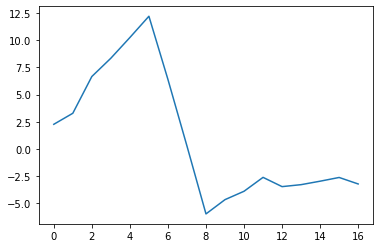

In [165]:

plt.plot(points)

In [63]:
points_dif = points[1:] - points[:-1]

In [64]:
points_dif

array([ 1.07592715,  2.54809631,  2.38945829,  2.20167539,  1.87509172,
       -6.0980516 , -5.70736973, -5.89056858,  0.89524159,  0.28624114,
        1.10335129,  0.15265054, -1.38399841,  0.48591005,  0.97174952,
       -1.00308459])

In [118]:
all_best = {}

for i in range(len(points_dif)):
    # cp = points_dif[i]
    best = (np.Inf, 0, -1, -1)
    for j in range(i+2, len(points_dif)):
        # next_p = points_dif[j]
        point_range = points_dif[i:(j+1)]
        mean = np.mean(point_range)
        std = np.std(point_range)
        # corr = np.corrcoef(point_range)
        if std < best[0]:
            best = (std, mean, i, j, std/((j-i+1) ** 1))
    # print('best in {}: ({}, {}) avg: {} / std: {}'.format(i, i, best[3], best[1], best[0]))
    if best[0] != np.Inf:
        if not all_best.get(best[3]):
            all_best.setdefault(best[3], [best])
        else:
            all_best[best[3]].append(best)

In [119]:
candidates = []

for end in all_best:
    points = all_best[end]
    interval = sorted(points, key=lambda x: x[-1])[0]
    print("Interval at ({}, {}) with a slope of {} and a score of {}".format(interval[2], interval[3]+1, interval[1], interval[-1]))
    candidates.append({'slope': interval[1], 'interval': (interval[2], interval[3]+1), 'metric': interval[-1]})

candidates = np.array(sorted(candidates, key=lambda x: x['interval'][0]))

Interval at (2, 5) with a slope of 2.155408467396986 and a score of 0.07084083003903408
Interval at (1, 4) with a slope of 2.3797433291381753 and a score of 0.04719749571849539
Interval at (3, 16) with a slope of -0.9316278207704927 and a score of 0.2214750307429749
Interval at (5, 8) with a slope of -5.89866330184815 and a score of 0.05319929390183515
Interval at (8, 11) with a slope of 0.7616113393712598 and a score of 0.11556945317511419
Interval at (9, 12) with a slope of 0.5140809901056972 and a score of 0.1400770227930932
Interval at (10, 15) with a slope of 0.2659325968563424 and a score of 0.1785036208632347
Interval at (11, 14) with a slope of -0.24847927464545347 and a score of 0.2714594655096043


In [120]:
candidates_removed = np.full(candidates.size, False)

# Detecting candidates inside each other
sz = len(candidates)
for i in range(sz):
    if candidates_removed[i] == True:
        continue
    
    ci = candidates[i]
    i0, i1 = ci['interval']
    for j in range(i+1, sz):
        cj = candidates[j]
        j0, j1 = cj['interval']
        print("({},{}), ({},{})".format(i0, i1, j0, j1))
        if i0 <= j0 and i1 >= j1 and ci['metric'] < cj['metric']:
            candidates_removed[j] = True

candidates = candidates[candidates_removed == False]

(1,4), (2,5)
(1,4), (3,16)
(1,4), (5,8)
(1,4), (8,11)
(1,4), (9,12)
(1,4), (10,15)
(1,4), (11,14)
(2,5), (3,16)
(2,5), (5,8)
(2,5), (8,11)
(2,5), (9,12)
(2,5), (10,15)
(2,5), (11,14)
(3,16), (5,8)
(3,16), (8,11)
(3,16), (9,12)
(3,16), (10,15)
(3,16), (11,14)
(5,8), (8,11)
(5,8), (9,12)
(5,8), (10,15)
(5,8), (11,14)
(8,11), (9,12)
(8,11), (10,15)
(8,11), (11,14)
(9,12), (10,15)
(9,12), (11,14)
(10,15), (11,14)


In [121]:
candidates

array([{'slope': 2.3797433291381753, 'interval': (1, 4), 'metric': 0.04719749571849539},
       {'slope': 2.155408467396986, 'interval': (2, 5), 'metric': 0.07084083003903408},
       {'slope': -0.9316278207704927, 'interval': (3, 16), 'metric': 0.2214750307429749},
       {'slope': -5.89866330184815, 'interval': (5, 8), 'metric': 0.05319929390183515},
       {'slope': 0.7616113393712598, 'interval': (8, 11), 'metric': 0.11556945317511419},
       {'slope': 0.5140809901056972, 'interval': (9, 12), 'metric': 0.1400770227930932},
       {'slope': 0.2659325968563424, 'interval': (10, 15), 'metric': 0.1785036208632347}],
      dtype=object)

In [150]:
final_intervals = []
candidates_merged = np.full(candidates.size, False)

# Detecting overlapping candidates
sz = len(candidates)
for i in range(sz):
    if candidates_merged[i]:
        continue

    candidates_merged[i] = True
    overlap_found = False
    overlap_interval = candidates[i]

    for j in range(i+1, sz):
        ci = candidates[j-1]
        i0, i1 = ci['interval']
        cj = candidates[j]
        j0, j1 = cj['interval']
        overlap = i1 - j0
        if overlap > 0:
            overlap_percent = np.mean([overlap/(i1-i0), overlap/(j1-j0)])
            slope_ratio = max(ci['slope'], cj['slope']) / min(ci['slope'], cj['slope'])
            std_ratio = max(ci['metric'], cj['metric']) / min(ci['metric'], cj['metric'])
            if overlap_percent > 0.5 and slope_ratio < 1.5 and std_ratio < 2:
                candidates_merged[j] = True
                cf = overlap_interval
                f0, f1 = cf['interval']
                new_slope = (cf['slope'] * (f1-f0) + cj['slope'] * (j1-j0)) / (f1-f0 + j1-j0)
                new_score = (cf['metric'] * (f1-f0) + cj['metric'] * (j1-j0)) / (f1-f0 + j1-j0)
                itv = {'slope': new_slope, 'interval': (f0, j1), 'metric': new_score}
                overlap_interval = itv
            else:
                if j == i+1 and cj['metric'] < ci['metric']:
                    candidates_merged[j] = True
                    overlap_interval = cj
        else:
            break
    
    final_intervals.append(overlap_interval)


In [151]:
final_intervals

[{'slope': 2.2675758982675807,
  'interval': (1, 5),
  'metric': 0.059019162878764735},
 {'slope': -5.89866330184815,
  'interval': (5, 8),
  'metric': 0.05319929390183515},
 {'slope': 0.6378461647384784,
  'interval': (8, 12),
  'metric': 0.1278232379841037},
 {'slope': 0.2659325968563424,
  'interval': (10, 15),
  'metric': 0.1785036208632347}]

In [159]:
def detect_significant_trends(points, x_scale):
    points = np.array(points)
    points_dif = points[1:] - points[:-1]
    all_best = {}

    for i in range(len(points_dif)):
        # cp = points_dif[i]
        best = (np.Inf, 0, -1, -1)
        for j in range(i+2, len(points_dif)):
            # next_p = points_dif[j]
            point_range = points_dif[i:(j+1)]
            mean = np.mean(point_range)
            std = np.std(point_range)
            # corr = np.corrcoef(point_range)
            if std < best[0]:
                best = (std, mean, i, j, std/((j-i+1) ** 1))
        # print('best in {}: ({}, {}) avg: {} / std: {}'.format(i, i, best[3], best[1], best[0]))
        if best[0] != np.Inf:
            if not all_best.get(best[3]):
                all_best.setdefault(best[3], [best])
            else:
                all_best[best[3]].append(best)
                
    candidates = []

    for end in all_best:
        points = all_best[end]
        interval = sorted(points, key=lambda x: x[-1])[0]
        print("Interval at ({}, {}) with a slope of {} and a score of {}".format(interval[2], interval[3]+1, interval[1], interval[-1]))
        candidates.append({'slope': interval[1], 'interval': (interval[2], interval[3]+1), 'metric': interval[-1]})

    candidates = np.array(sorted(candidates, key=lambda x: x['interval'][0]))
    print('cand', candidates)

    candidates_removed = np.full(candidates.size, False)

    # Detecting candidates inside each other
    sz = len(candidates)
    for i in range(sz):
        if candidates_removed[i] == True:
            continue
        
        ci = candidates[i]
        i0, i1 = ci['interval']
        for j in range(i+1, sz):
            cj = candidates[j]
            j0, j1 = cj['interval']
            print("({},{}), ({},{})".format(i0, i1, j0, j1))
            if i0 <= j0 and i1 >= j1 and ci['metric'] < cj['metric']:
                candidates_removed[j] = True

    candidates = candidates[candidates_removed == False]

    final_intervals = []
    candidates_merged = np.full(candidates.size, False)

    # Detecting overlapping candidates
    sz = len(candidates)
    for i in range(sz):
        if candidates_merged[i]:
            continue

        candidates_merged[i] = True
        overlap_found = False
        overlap_interval = candidates[i]

        for j in range(i+1, sz):
            ci = candidates[j-1]
            i0, i1 = ci['interval']
            cj = candidates[j]
            j0, j1 = cj['interval']
            overlap = i1 - j0
            if overlap > 0:
                overlap_percent = np.mean([overlap/(i1-i0), overlap/(j1-j0)])
                slope_ratio = max(ci['slope'], cj['slope']) / min(ci['slope'], cj['slope'])
                std_ratio = max(ci['metric'], cj['metric']) / min(ci['metric'], cj['metric'])
                if overlap_percent > 0.5 and slope_ratio < 1.5 and std_ratio < 2:
                    candidates_merged[j] = True
                    cf = overlap_interval
                    f0, f1 = cf['interval']
                    new_slope = (cf['slope'] * (f1-f0) + cj['slope'] * (j1-j0)) / (f1-f0 + j1-j0)
                    new_score = (cf['metric'] * (f1-f0) + cj['metric'] * (j1-j0)) / (f1-f0 + j1-j0)
                    itv = {'slope': new_slope, 'interval': (f0, j1), 'metric': new_score}
                    overlap_interval = itv
                else:
                    if j == i+1 and cj['metric'] < ci['metric']:
                        candidates_merged[j] = True
                        overlap_interval = cj
            else:
                break
        
        overlap_interval['interval'] *= x_scale
        final_intervals.append(overlap_interval)
    
    return final_intervals


In [166]:
detect_significant_trends(points, 1)

Interval at (2, 5) with a slope of 1.8444415023791498 and a score of 0.03934341726943799
Interval at (13, 16) with a slope of 0.021277121946403337 and a score of 0.14563781877710993
Interval at (5, 8) with a slope of -6.04991284067349 and a score of 0.061091932272408465
Interval at (8, 11) with a slope of 1.118621550301244 and a score of 0.0827147139011785
Interval at (12, 15) with a slope of 0.2803624186239209 and a score of 0.023697335755615754
cand [{'slope': 1.8444415023791498, 'interval': (2, 5), 'metric': 0.03934341726943799}
 {'slope': -6.04991284067349, 'interval': (5, 8), 'metric': 0.061091932272408465}
 {'slope': 1.118621550301244, 'interval': (8, 11), 'metric': 0.0827147139011785}
 {'slope': 0.2803624186239209, 'interval': (12, 15), 'metric': 0.023697335755615754}
 {'slope': 0.021277121946403337, 'interval': (13, 16), 'metric': 0.14563781877710993}]
(2,5), (5,8)
(2,5), (8,11)
(2,5), (12,15)
(2,5), (13,16)
(5,8), (8,11)
(5,8), (12,15)
(5,8), (13,16)
(8,11), (12,15)
(8,11), (1

[{'slope': 1.8444415023791498,
  'interval': (2, 5),
  'metric': 0.03934341726943799},
 {'slope': -6.04991284067349,
  'interval': (5, 8),
  'metric': 0.061091932272408465},
 {'slope': 1.118621550301244,
  'interval': (8, 11),
  'metric': 0.0827147139011785},
 {'slope': 0.2803624186239209,
  'interval': (12, 15),
  'metric': 0.023697335755615754},
 {'slope': 0.021277121946403337,
  'interval': (13, 16),
  'metric': 0.14563781877710993}]